In [12]:
from matplotlib import pyplot as plt
from scipy import signal
import numpy as np
from scipy.optimize import curve_fit,minimize
plt.style.use('http://www.normalesup.org/~mrieu/Python/stylelib/mr.mplstyle') #my own style, can remove
import sys
sys.path.insert(0, './PyQtRod') #insert PyQtRod path to use the reader module NIfile. Change to the location of PyQtRod.


In [13]:
from NIfile import NIfile

In [14]:
tdmspath = "2022_04_16_strept/2022_06_14_5_strept10.tdms" #File number

Very good rotor 135 Hz in the plane

In [15]:
f = NIfile(tdmspath,dec=1,max_size=20000)

10000.0 -1


# Draw PSD of all channels

In [16]:
start = 2000000 #starting index to load file from memory
stop = 4000000
a = [0.95,0.91,1.09,1]  #Correction coefficients / can be found using the corresponding module in PyQtRod
b = [0,0,0,0]
freq = f.freq

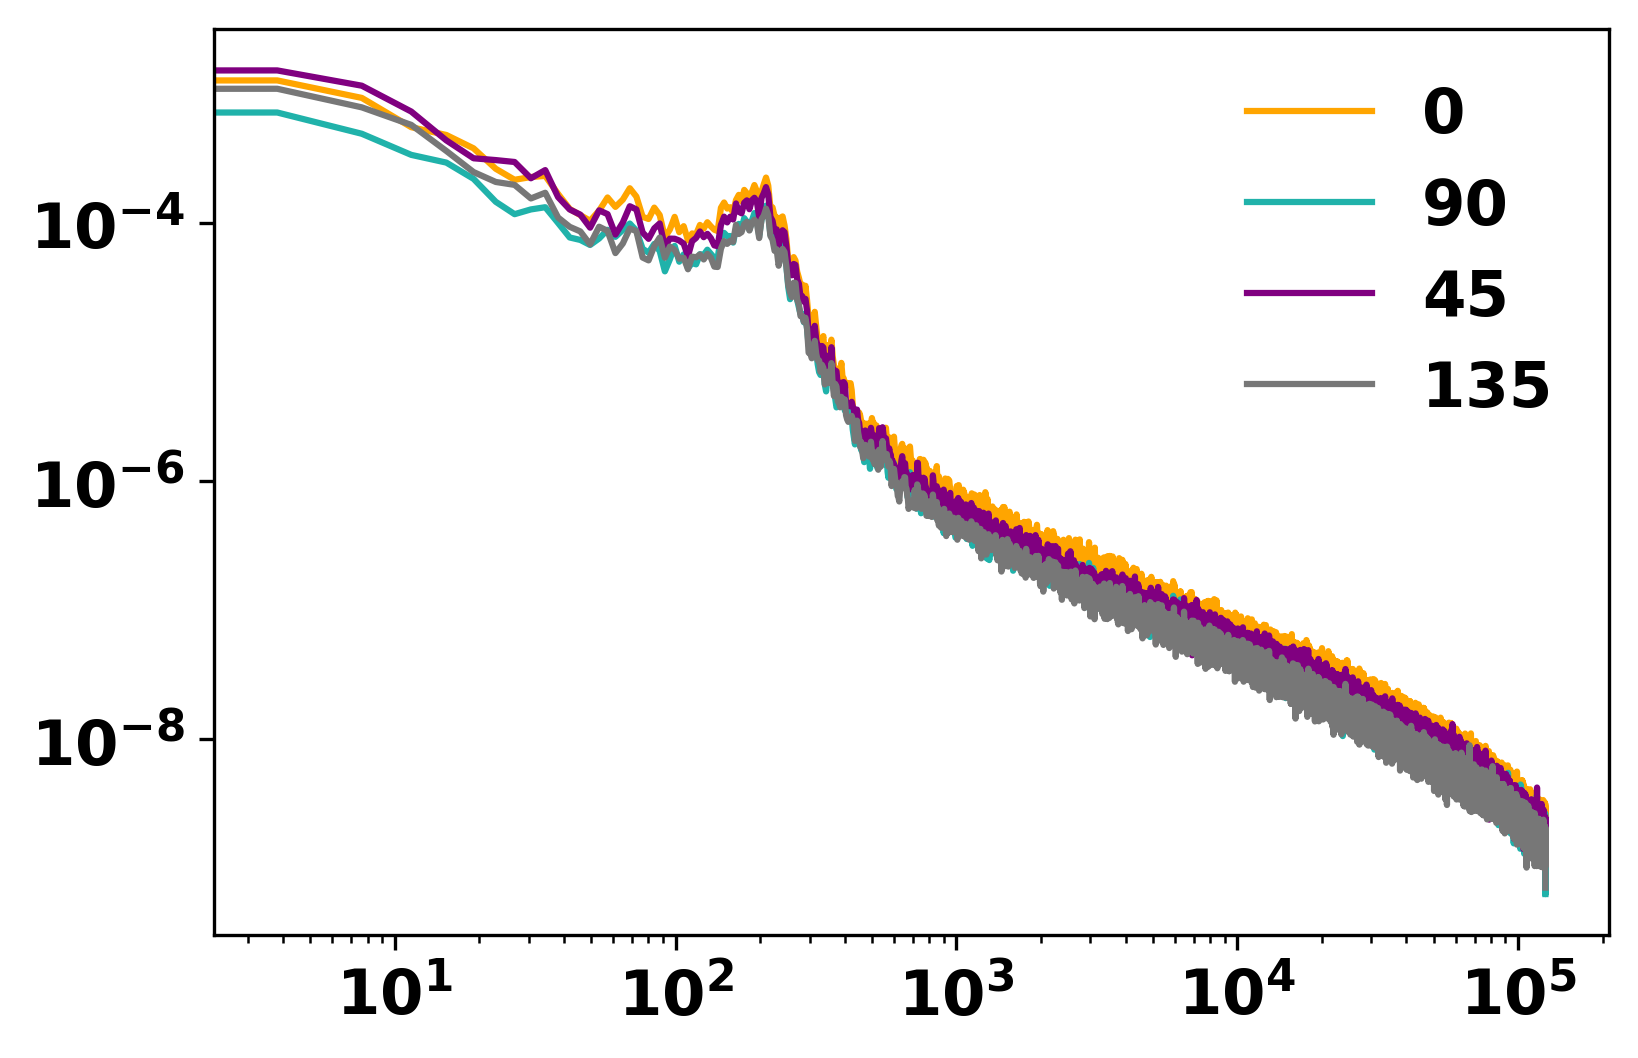

In [21]:
channels = []
for i in range(4):
    channels.append(f.channels[i][start:stop]*a[i]+b[i])
pol_ind = f.get_pol_ind(["0","90","45","135"])
c0,c90,c45,c135 = [channels[pol_ind[i]] for i in range(len(pol_ind))]

times = np.arange(start,stop)/freq #computes times corresponding to indexes

nps = 2**16
f0, Pxx_den0 = signal.welch(c0, 250e3, nperseg=nps)
f90, Pxx_den90 = signal.welch(c90, 250e3, nperseg=nps)
f45, Pxx_den45 = signal.welch(c135, 250e3, nperseg=nps)
f135, Pxx_den135 = signal.welch(c45, 250e3, nperseg=nps)

plt.plot(f0, Pxx_den0,label="0")
plt.plot(f90, Pxx_den90,label="90")
plt.plot(f45, Pxx_den45,label="45")
plt.plot(f135, Pxx_den135,label="135")

plt.yscale("log")
plt.xscale("log")
plt.legend()


## Draw Anisotropies

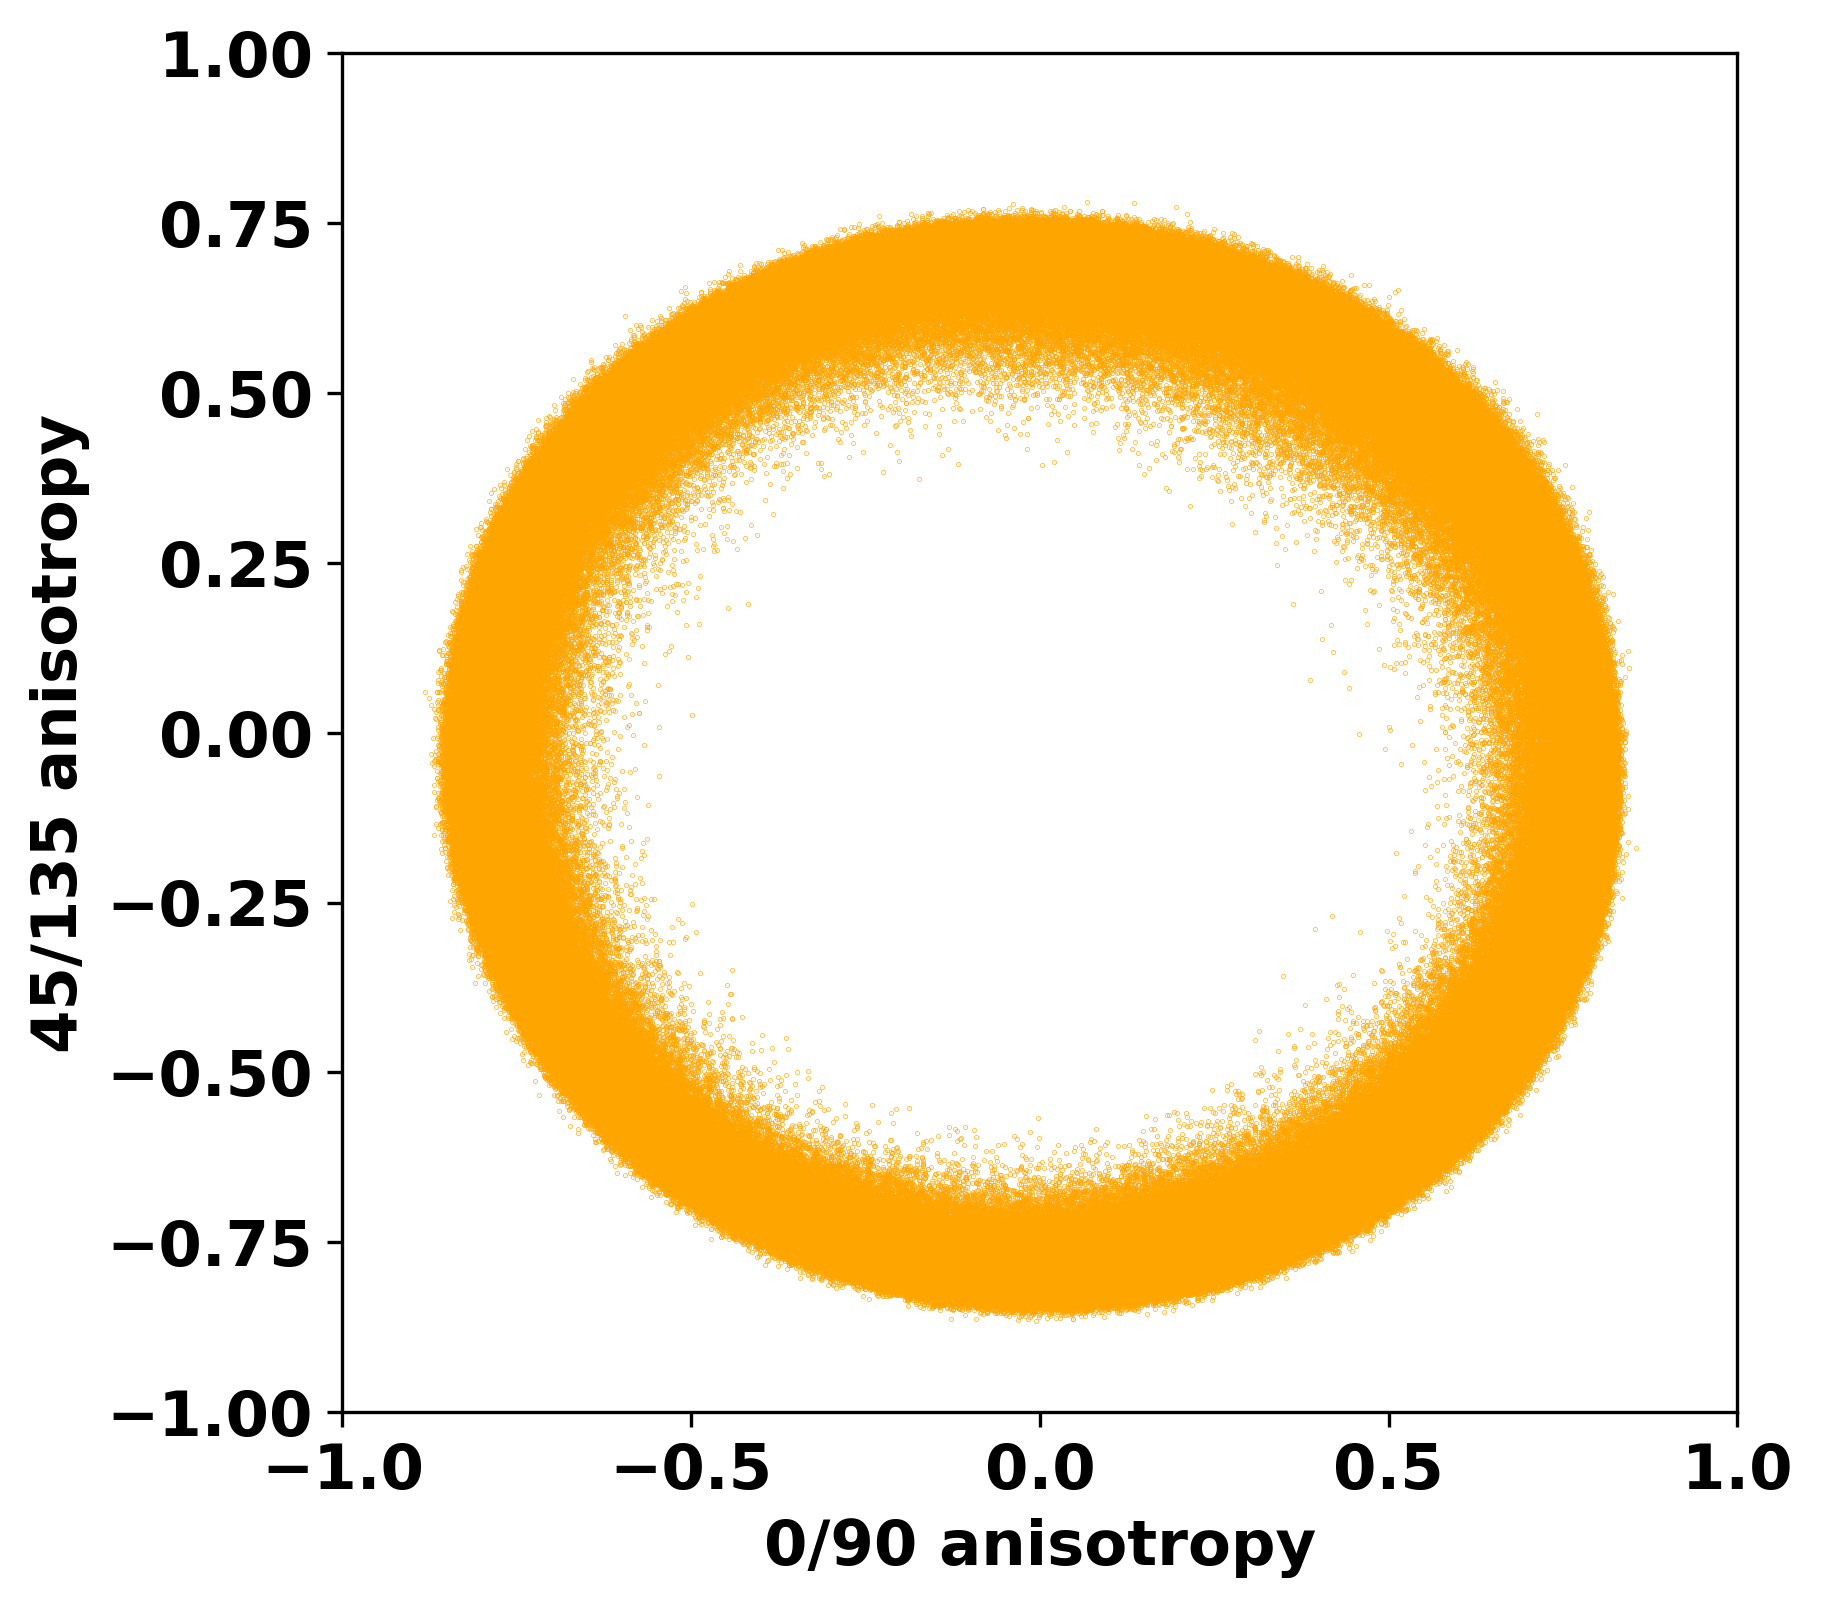

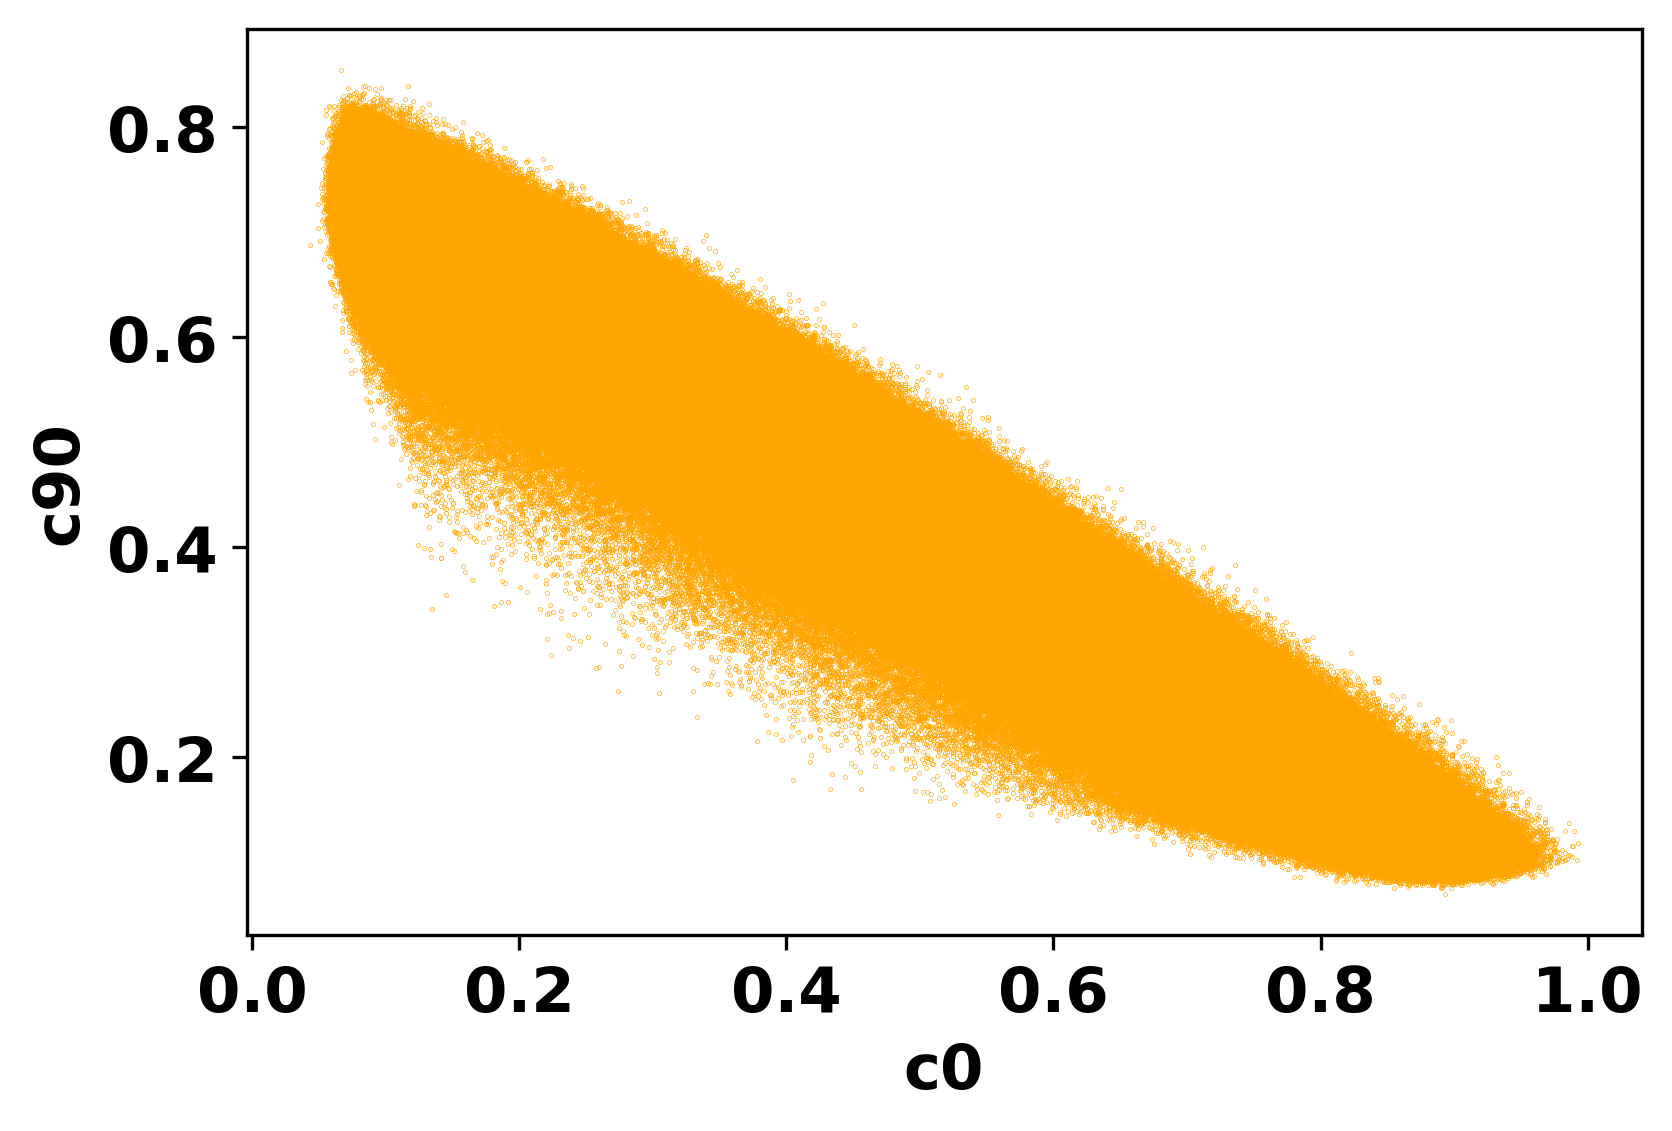

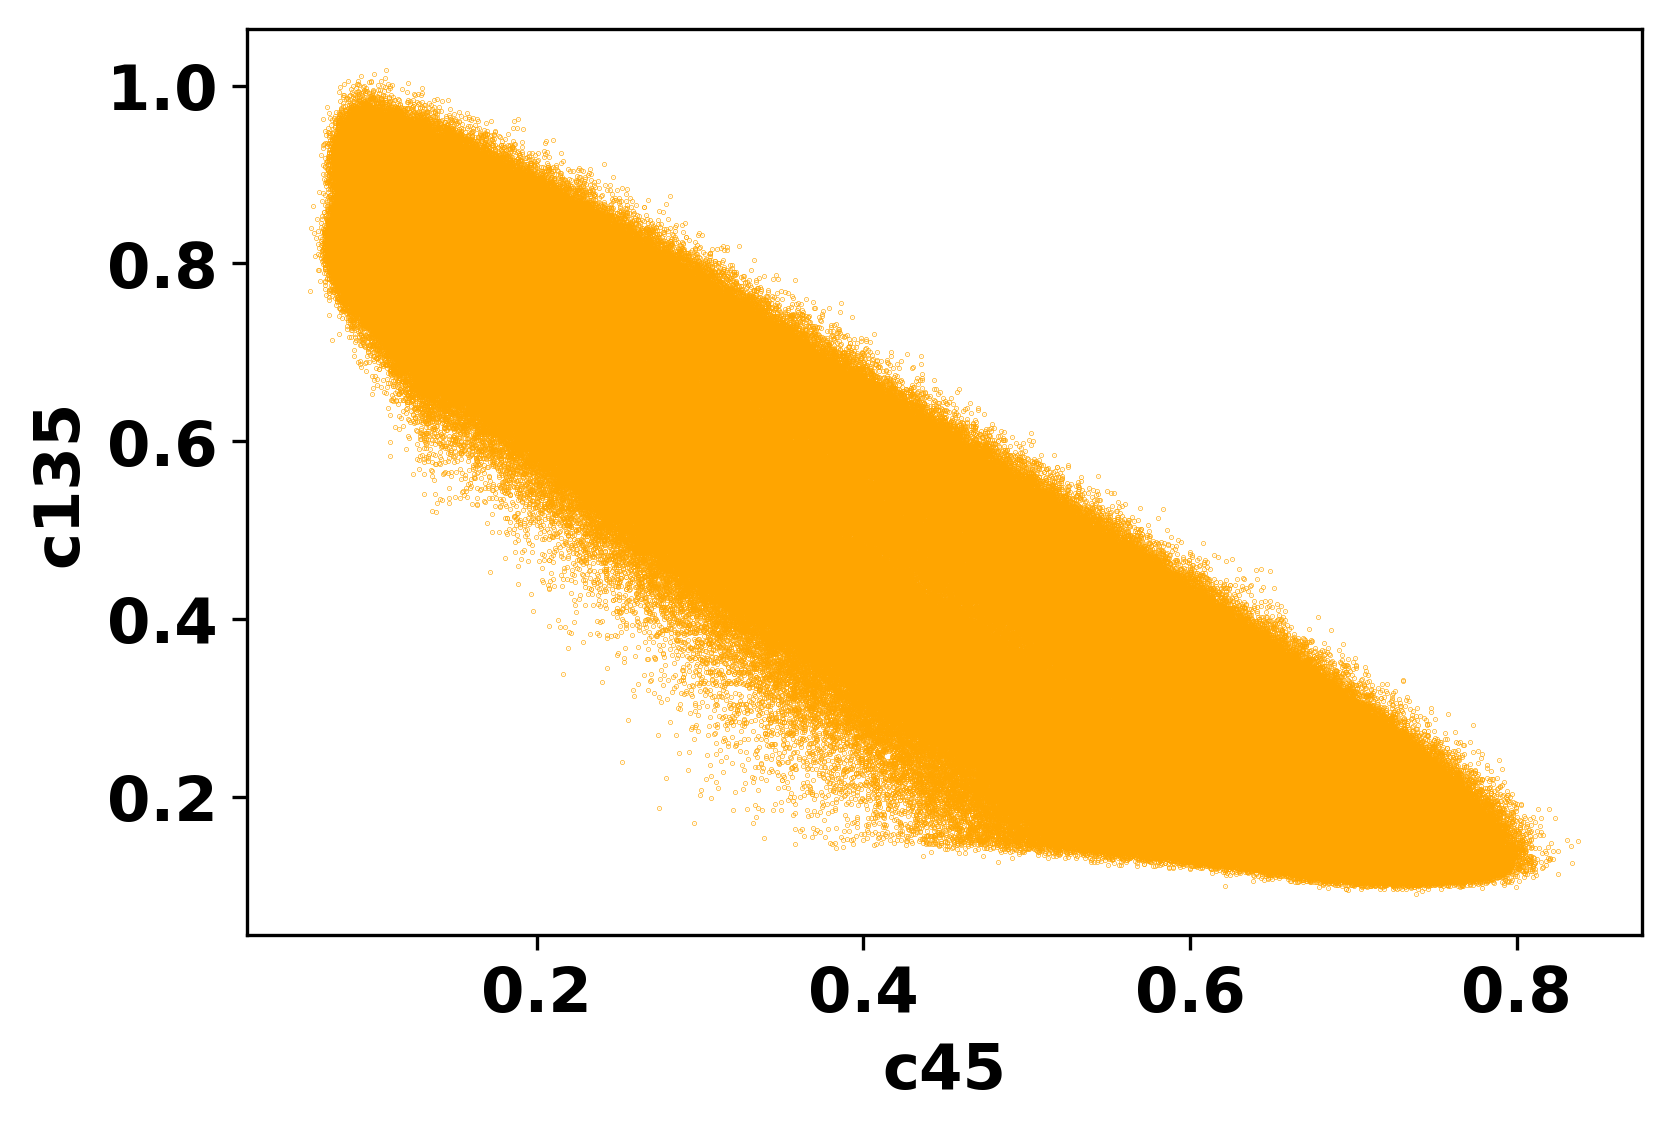

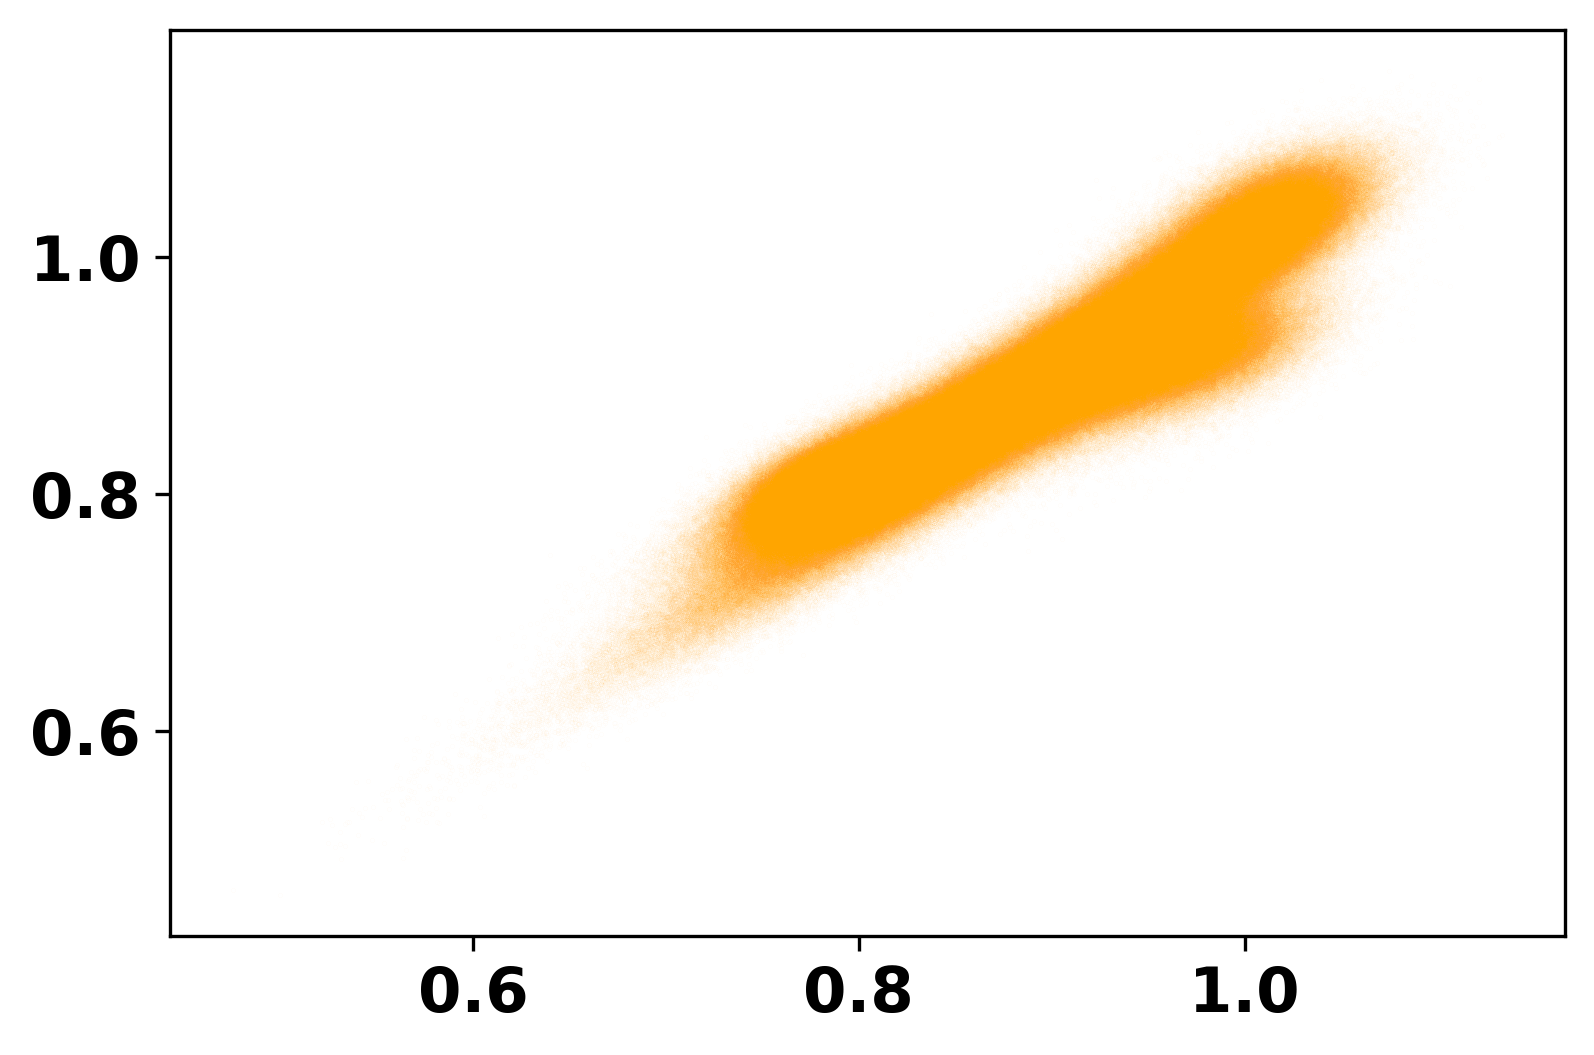

In [22]:
plt.figure(figsize=[6,6])
plt.xlim([-1,1])
plt.ylim([-1,1])

I0 = (c0 - c90) / (c0 + c90)
I1 = (c45 - c135) / (c45 + c135)
plt.plot(I0,I1,'.',ms=0.3)
plt.xlabel("0/90 anisotropy")
plt.ylabel("45/135 anisotropy")
plt.show()
plt.plot(c0,c90,'.',ms=0.3)
plt.xlabel("c0")
plt.ylabel("c90")
plt.show()
plt.plot(c45,c135,'.',ms=0.3)
plt.xlabel("c45")
plt.ylabel("c135")
plt.show()
plt.plot(c0+c90,c45+c135,'.',ms=0.01)


## Function that computes Fourkas formula

In [23]:
def Fourkas(c0,c90,c45,c135,theta0=0,phi0=0):
    alpha = np.arcsin(1.3/1.51)
    A=1/6-1/4*np.cos(alpha)+1/12*np.cos(alpha)**3
    B=1/8*np.cos(alpha)-1/8*np.cos(alpha)**3
    C = 7/48-np.cos(alpha)/16-np.cos(alpha)**2/16-np.cos(alpha)**3/48
    phi = 0.5 * np.arctan2((c45/2-c135/2),(c0/2-c90/2)) #thhis one I modified to symmetrize
    cs = np.cos(2*phi)
    ss = np.sin(2*phi)
    Itots2thet = 1/2/A*((1-B/C/cs)*c0+(1+B/C/cs)*c90)
    theta1 = np.arcsin(np.sqrt((c0-c90)/(2*Itots2thet*C*cs)))
    theta2 = np.arcsin(np.sqrt((c45-c135)/(2*Itots2thet*C*ss)))
    v1 = np.array([np.sin(theta1)*np.cos(phi),np.sin(theta1)*np.sin(phi),np.cos(theta1)])
    v2 = np.array([np.sin(theta0)*np.cos(phi0),np.sin(theta0)*np.sin(phi0),np.cos(theta0)])
    fac = v1.transpose().dot(v2)
    Itot = Itots2thet / np.sin(theta1)**2


    Itotcor = Itots2thet / fac**2
    return phi,theta1,Itots2thet,Itot,Itotcor

In [24]:
phi,theta1,Itots2theta,Itot,Itotcor = Fourkas(c0,c90,c45,c135)#,phi0=result.x[0],theta0=result.x[1])

/tmp/ipykernel_14362/3720800981.py:15: RuntimeWarning: divide by zero encountered in true_divide
  Itot = Itots2thet / np.sin(theta1)**2


In [25]:
phi2 = np.unwrap(phi,period = np.pi)

Text(0.5, 0, 'Times (s)')

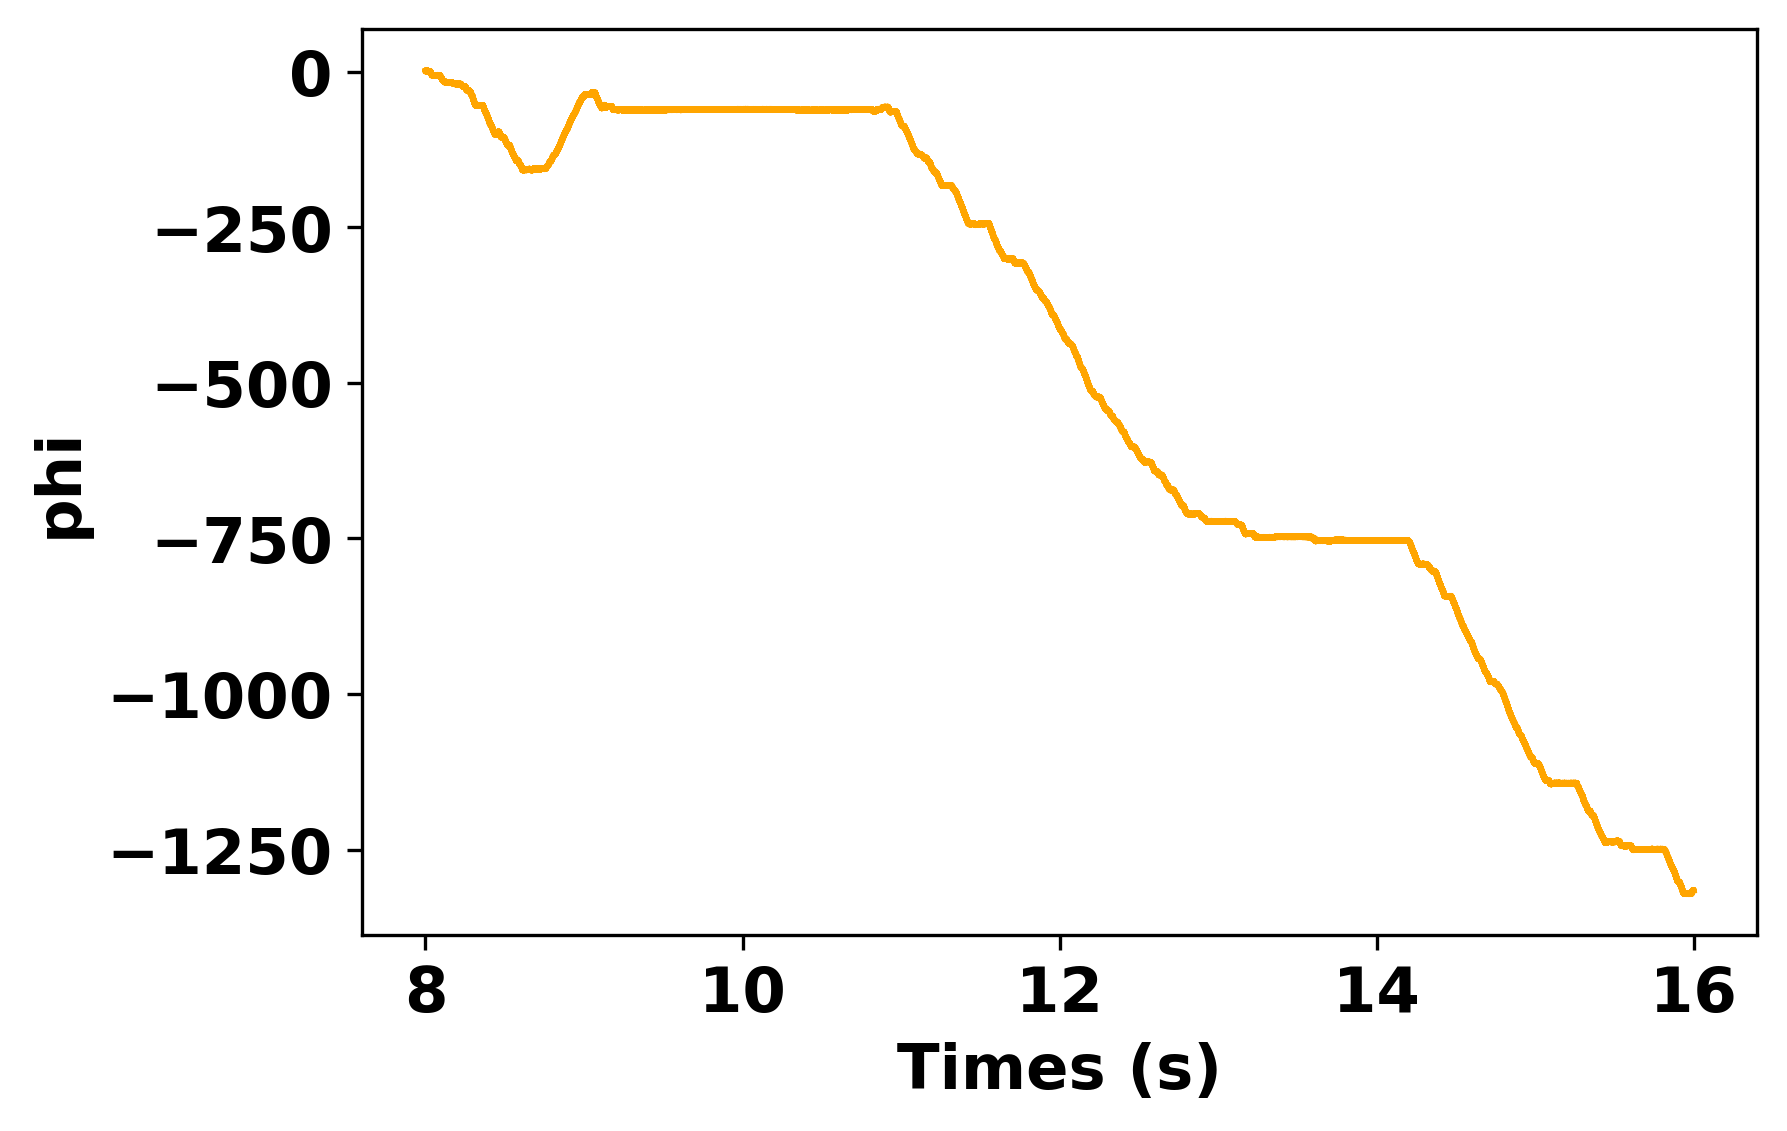

In [27]:
plt.plot(times,phi2)
plt.ylabel("phi")
plt.xlabel("Times (s)")

417.8174488918815


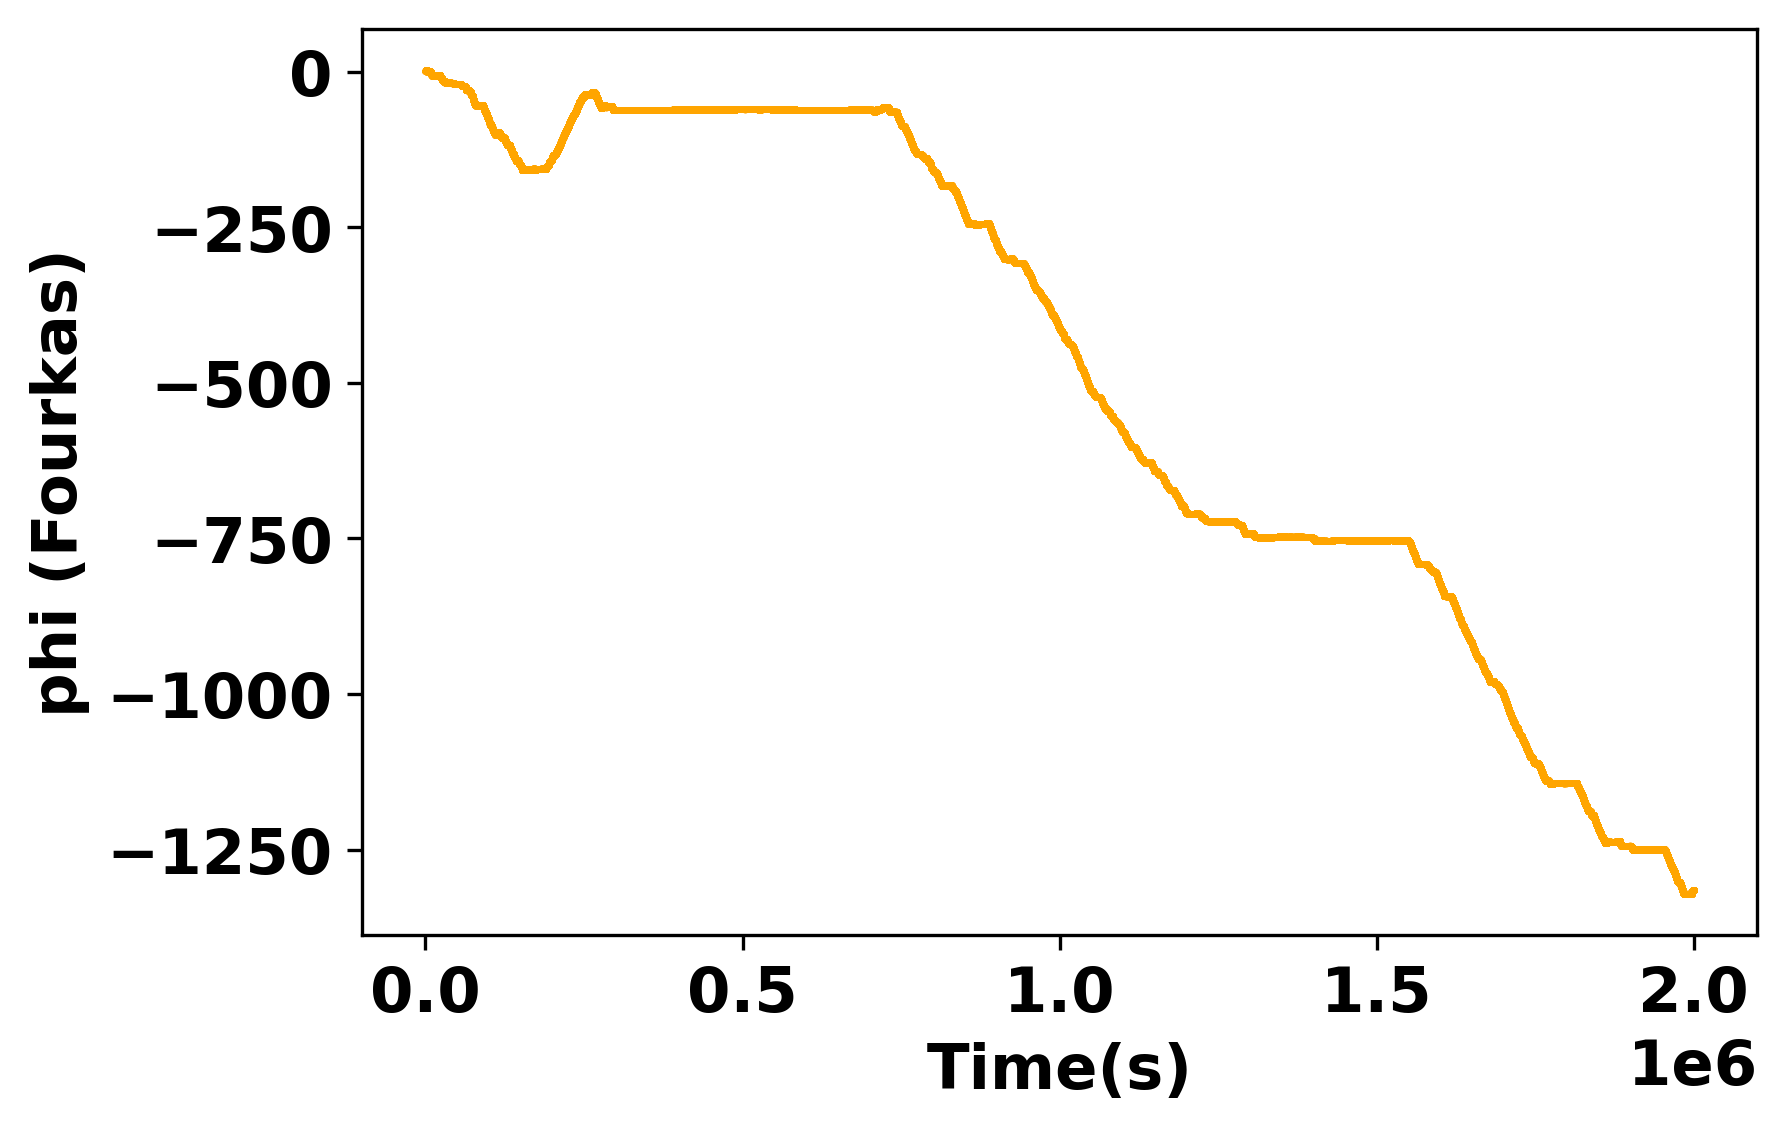

-3.0654112212468356 6.112261737300972
-1.1430518427459209 -5.102428550506142
-2.1601837747586843 6.1067823626568325


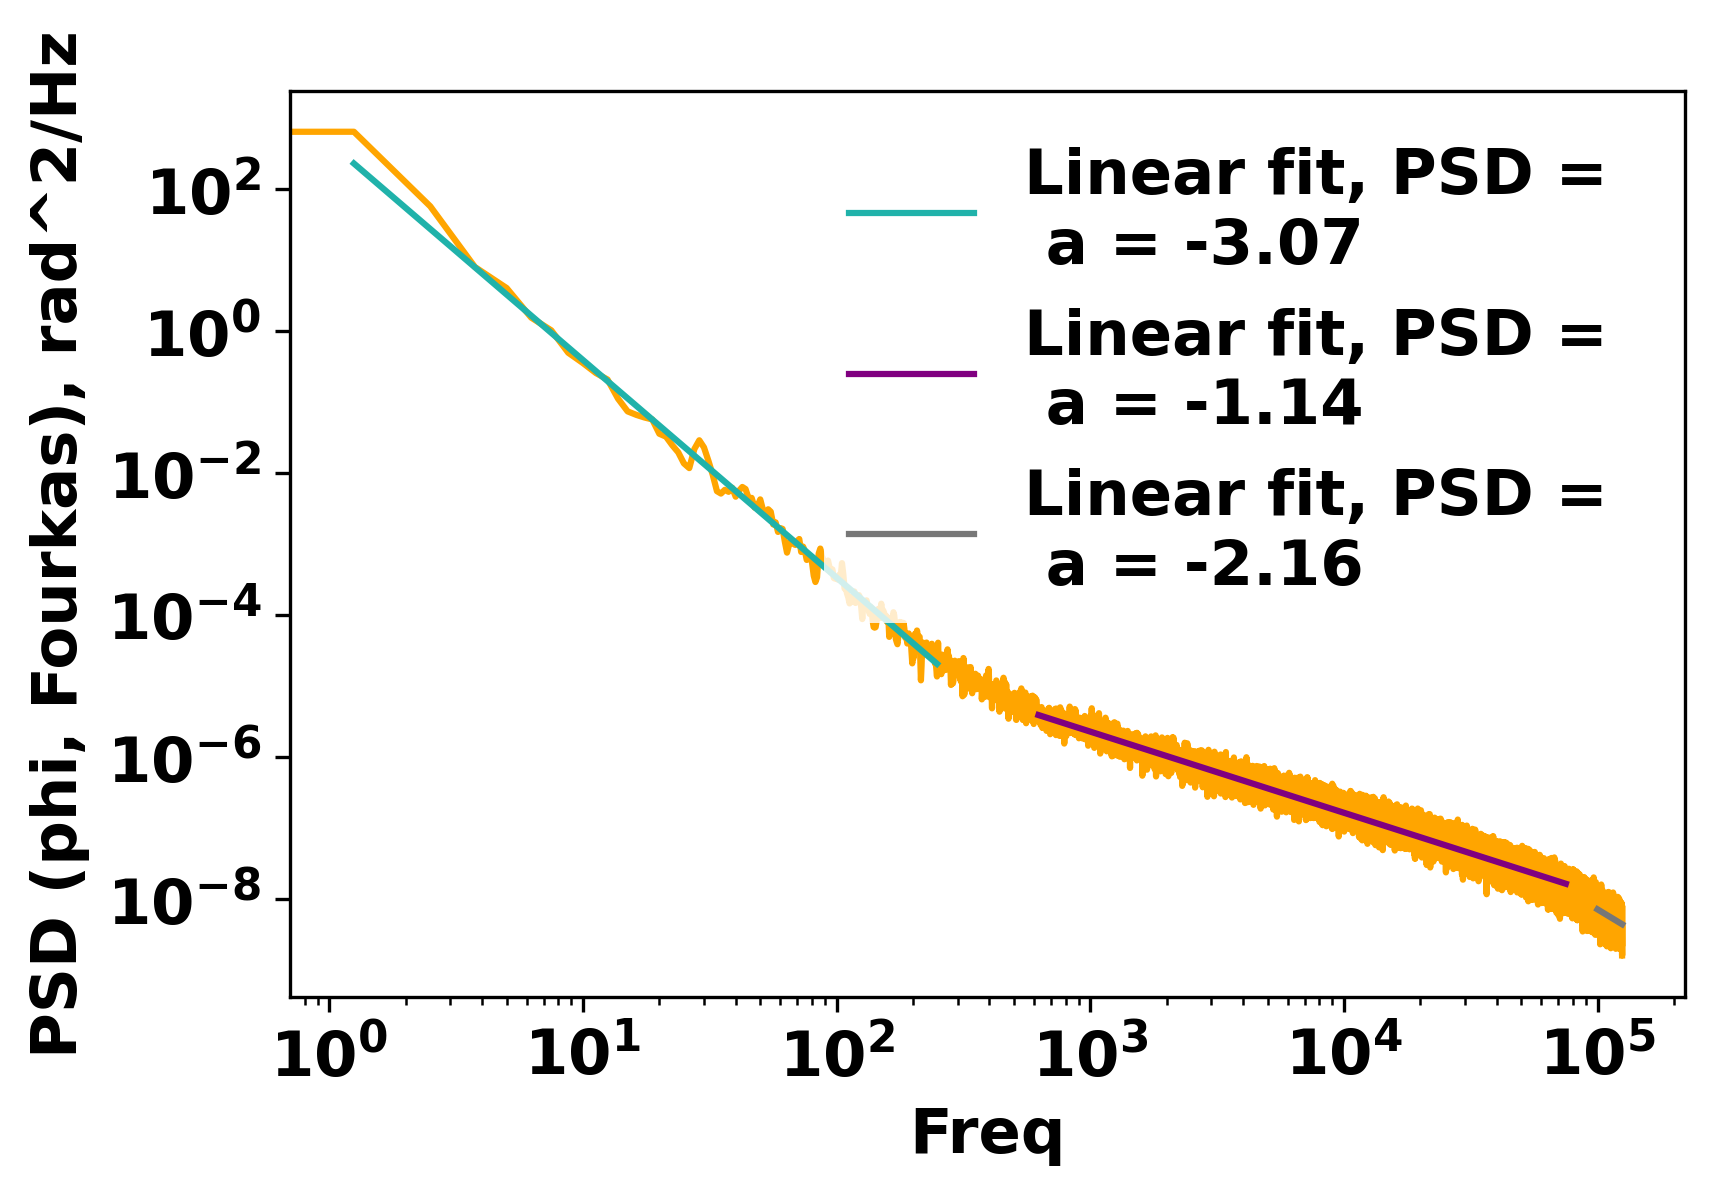

In [33]:
plt.plot(phi2[:],'.',ms=1)
print(np.std(phi2[:]))
plt.ylabel("phi (Fourkas)")
plt.xlabel("Time(s)")
plt.show()

nps = 200000
f0, Pxx_den0 = signal.welch(phi2[:], 250e3, nperseg=nps)

plt.plot(f0, Pxx_den0)

plt.yscale("log")
plt.xscale("log")


#f0, Pxx_den0 = signal.welch(phi2[start2:stop2], 250e3, nperseg=nps)

#plt.plot(f0, Pxx_den0,label="0")

plt.yscale("log")
#plt.xlim([1,10000])
plt.xlabel("Freq")
plt.ylabel("PSD (phi, Fourkas), rad^2/Hz")

a,b = np.polyfit(np.log(f0[1:200]),np.log(Pxx_den0[1:200]),1)
print(a,b)

plt.plot(f0[1:200],np.exp(b)*f0[1:200]**a,label="Linear fit, PSD = \n a = "+"{:.2f}".format(a))
plt.legend()

a,b = np.polyfit(np.log(f0[800:3000]),np.log(Pxx_den0[800:3000]),1)
print(a,b)

plt.plot(f0[500:60000],np.exp(b)*f0[500:60000]**a,label="Linear fit, PSD = \n a = "+"{:.2f}".format(a))
plt.legend()

a,b = np.polyfit(np.log(f0[80000:100000]),np.log(Pxx_den0[80000:100000]),1)
print(a,b)

plt.plot(f0[80000:100000],np.exp(b)*f0[80000:100000]**a,label="Linear fit, PSD = \n a = "+"{:.2f}".format(a))
plt.legend()





# Display an animation in 3D

In [37]:
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

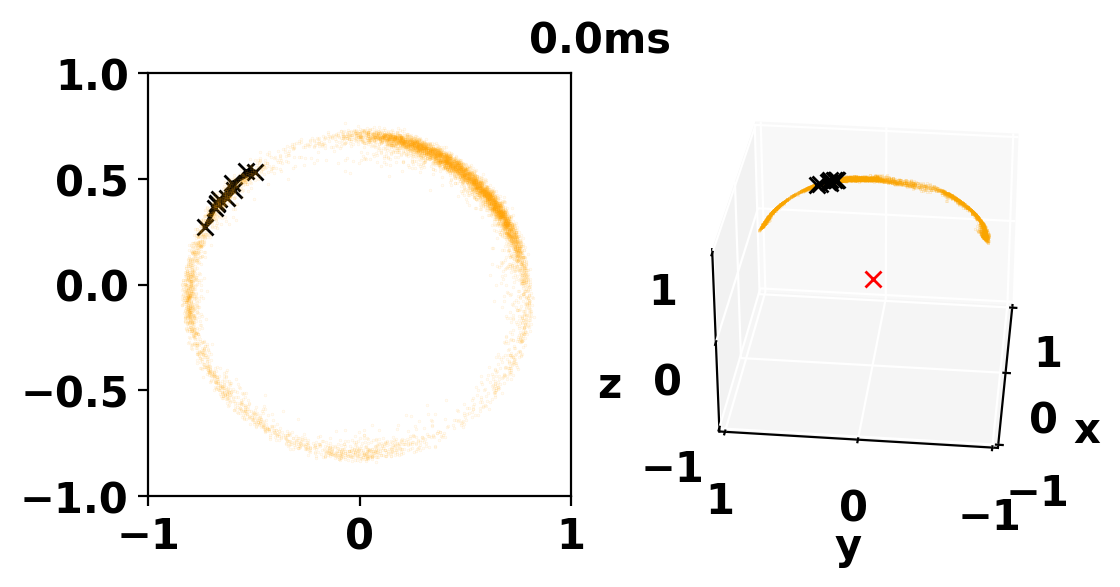

In [38]:
x = I0
y = I1
step = 10
imin = 2400
imax = 10000
anirange = 400
anistart = 2400
fig = plt.figure(dpi=200)
ax2D = fig.add_subplot(1, 2, 1)
line2D, = ax2D.plot(x[0], y[0],'-x',color='k')
ax2D.plot(I0[imin:imax],I1[imin:imax],'.',ms=0.3,alpha=0.2)
time = ax2D.text(0.8,1.1, str(0.0000)+ "ms")


x2D = I0
y2D = I1

ax3D = fig.add_subplot(1,2,2, projection='3d')

ax3D.plot(np.sin(theta1[imin:imax])*np.cos(phi[imin:imax]),np.sin(theta1[imin:imax])*np.sin(phi[imin:imax]),np.cos(theta1[imin:imax]),'.',ms=0.1)
ax3D.view_init(elev=30., azim=90)
x3D = np.sin(theta1[imin:imax])*np.cos(phi[imin:imax])
y3D = np.sin(theta1[imin:imax])*np.sin(phi[imin:imax])
z3D = np.cos(theta1[imin:imax])

ax2D.set(xlim=[-1, 1], ylim=[-1, 1], aspect=1)
ax3D.set(xlim=[-1, 1], ylim=[-1, 1],zlim=[-1, 1], aspect="auto")

ax3D.plot([0],[0],[0],"x",color='red') #origin

line3D, = ax3D.plot(x3D[0], y3D[0],z3D[0],'-x',color='k')


ax3D.set_xlabel("x")
ax3D.set_ylabel("y")
ax3D.set_zlabel("z")

#time = ax.text(0.8,1.1, str(0.0000)+ "ms")

def init():
    ax2D.set_xlim(0,0.8)
    ax2D.set_ylim(-0.6, 0.1)
    ax3D.set_xlim([-1,1])
    ax3D.set_ylim([-1,1])
    ax3D.set_zlim([-1,1])
    ax2D.set(xlim=[-1,1], ylim=[-1, 1], aspect=1)
    ax3D.set(xlim=[-1, 1], ylim=[-1, 1],zlim=[-1, 1], aspect="auto")

    return line2D,line3D,

def update(num, x2D,y2D,x3D, y3D, z3D,line2D,line3D):
    line2D.set_data((x2D[num:num+step],y2D[num:num+step]))
    line3D.set_data((x3D[num:num+step],y3D[num:num+step]))
    line3D.set_3d_properties(z3D[num:num+step])
    if num%15 == 0:
        ax3D.view_init(elev=30, azim=num/15)

    return line2D, line3D,

ani = animation.FuncAnimation(fig, update, np.arange(anistart,anirange+anistart,int(step/10)), fargs=[x2D,y2D,x3D, y3D, z3D,line2D,line3D],
                              interval=50, init_func=init,blit=True)
HTML(ani.to_html5_video())
